## Physics-Informed Neural Network for Lorenz 96 System
This notebook demonstrates how to build a Physics-Informed Neural Network (PINN) for the Lorenz 96 system, combining physics-based modeling with data-driven learning.

### Step 1: Define the Physics Constraints
We start by expressing the Lorenz 96 system as a set of ordinary differential equations (ODEs).

In [14]:
import numpy as np
import tensorflow as tf

def lorenz_96_derivatives_tf(x, F=8):
    N = tf.shape(x)[0]
    dxdt = tf.zeros_like(x)
    for i in range(N):
        dxdt_i = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
        dxdt = tf.tensor_scatter_nd_update(dxdt, [[i]], [dxdt_i])
    return dxdt


### Step 2: Design the Neural Network Architecture
Next, we create a neural network using TensorFlow to predict the derivatives of the Lorenz 96 system.

In [15]:


N = 5

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(N,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(N)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                384       
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 5)                 325       
                                                                 
Total params: 4869 (19.02 KB)
Trainable params: 4869 (19.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Step 3: Embed Physics Constraints as Loss Terms
We embed the physics constraints of the Lorenz 96 system as loss terms in the neural network.

In [16]:
def physics_loss(y_true, y_pred):
    predicted_derivatives = lorenz_96_derivatives_tf(y_pred)
    return tf.reduce_mean(tf.square(predicted_derivatives - y_true))

def combined_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_pred - y_true))
    return mse_loss + physics_loss(y_true, y_pred)

model.compile(optimizer='adam', loss=combined_loss)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                384       
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 5)                 325       
                                                                 
Total params: 4869 (19.02 KB)
Trainable params: 4869 (19.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Step 4: Generate Training Data
We simulate the Lorenz 96 system to generate training data for the neural network.

In [18]:
from scipy.integrate import odeint

F = 8

def L96(x, t):
    return lorenz_96_derivatives_tf(x, F)

x0 = F * np.ones(N)
x0[0] += 0.01
t = np.arange(0.0, 30.0, 0.01)
x = odeint(L96, x0, t)
dxdt = np.array([L96(xi, 0) for xi in x])

X_train = x
y_train = dxdt

### Step 5: Train the Neural Network
We train the neural network using the training data, and the model learns how the Lorenz 96 system behaves.

In [19]:
model.fit(X_train, y_train, epochs=1000, batch_size=32)

Epoch 1/1000
94/94 [==============================] - 1s 3ms/step - loss: 932.3212
Epoch 2/1000
94/94 [==============================] - 0s 3ms/step - loss: 926.1166
Epoch 3/1000
94/94 [==============================] - 0s 3ms/step - loss: 926.5735
Epoch 4/1000
94/94 [==============================] - 0s 3ms/step - loss: 926.3136
Epoch 5/1000
94/94 [==============================] - 0s 3ms/step - loss: 925.8212
Epoch 6/1000
94/94 [==============================] - 0s 3ms/step - loss: 924.6423
Epoch 7/1000
94/94 [==============================] - 0s 3ms/step - loss: 924.0548
Epoch 8/1000
94/94 [==============================] - 0s 3ms/step - loss: 924.8306
Epoch 9/1000
94/94 [==============================] - 0s 3ms/step - loss: 924.4770
Epoch 10/1000
94/94 [==============================] - 0s 3ms/step - loss: 924.0390
Epoch 11/1000
94/94 [==============================] - 0s 3ms/step - loss: 922.9482
Epoch 12/1000
94/94 [==============================] - 0s 3ms/step - loss: 923.5176
E

### Step 6: Evaluate and Use the Hybrid Model
Finally, we validate and utilize the trained PINN for various tasks such as forecasting or analysis.

In [21]:
# Initial state for test data
x0_test = F * np.ones(N)
x0_test[0] += 0.02  # Slightly different initial condition

# Time points for test data
t_test = np.arange(0.0, 30.0, 0.01)

# Solve the differential equations for test data
x_test = odeint(lorenz_96_derivatives_tf, x0_test, t_test)

# Compute the derivatives for test data
dxdt_test = np.array([lorenz_96_derivatives_tf(xi, 0) for xi in x_test])

# Test data
X_test = x_test
y_test = dxdt_test


In [22]:
test_loss = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)


94/94 [==============================] - 2s 1ms/step - loss: 14266.9424
Test Loss: 14266.9423828125


94/94 [==============================] - 0s 992us/step


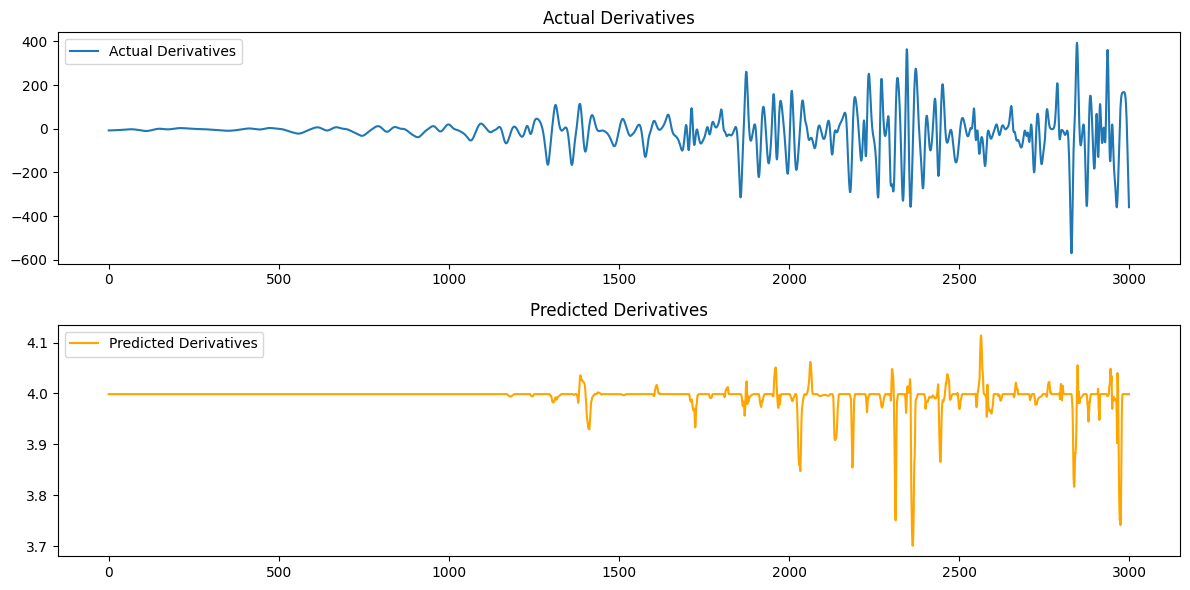

In [24]:
import matplotlib.pyplot as plt

# Predict the derivatives for the test data
predictions = model.predict(X_test)

# Choose a specific variable to visualize (e.g., the first variable)
variable_index = 0

plt.figure(figsize=(12, 6))

# Plot the actual derivatives for the chosen variable
plt.subplot(2, 1, 1)
plt.plot(y_test[:, variable_index], label="Actual Derivatives")
plt.title("Actual Derivatives")
plt.legend()

# Plot the predicted derivatives for the chosen variable
plt.subplot(2, 1, 2)
plt.plot(predictions[:, variable_index], label="Predicted Derivatives", color="orange")
plt.title("Predicted Derivatives")
plt.legend()

plt.tight_layout()
plt.show()
